In [0]:
# Taken from https://github.com/GunhoChoi/AnoGAN-Pytorch

In [38]:
!nvidia-smi

Mon Nov 11 10:55:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.183      Driver Version: 384.183      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000C93:00:00.0 Off |                    0 |
| N/A   50C    P0    73W / 149W |  11024MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00002BD8:00:00.0 Off |                    0 |
| N/A   82C    P0   113W / 149W |   4930MiB / 11439MiB |     95%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [32]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1,2" # set gpu number to use

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# Постановка задачи

Задача поиска аномалий - находить объекты, отличные от нормальных данных

**Примеры:** поиск сбоев, атак, ботов и другого аномального поведения или объектов

Как правило, ***основное отличие задачи поиска аномалий от задачи бинарной классификации*** заключается в том, что ***аномалий*** в выборке ***намного меньше или нет вообще***!

В связи с этим, большинство алгоритмов поиска аномалий, таких как OneClass-SVM и Isolation Forest, основываются на ***гипотезе о компактности***, когда нормальные объекты образуют некоторый кластер или группу кластеров (см. рис. ниже), а аномалии выходят за пределы этих кластеров
![](https://developer.mindsphere.io/apis/analytics-anomalydetection/images/DBSCAN.png)


Для экспериментов будем использовать датасет рукописных цифр MNIST

In [3]:
batch_size = 64 # по какому количеству объектов выборки будем оценивать градиент 
learning_rate = 0.001 # скорость обучения (шаг оптимизатора)
num_gpus = 1
anomaly_digit = 0 # какую цифру примем за аномалию
num_anomalies = 50 # количество используемых аномалий. В обучении не должно использоваться больше указанного числа!

In [4]:
class AnoDataset(torch.utils.data.Dataset):
    def __init__(self, data, anomaly, num_anomalies=None):
        self._anomaly = anomaly
        self._data = data
        labels = torch.Tensor([label for image, label in data])
        mask_anomaly = (labels == anomaly)
        self._ix_anomaly = torch.where(mask_anomaly)[0]
        self._ix_ordinary = torch.where(~mask_anomaly)[0]
        if num_anomalies is None:
            self._num_anomalies = len(self._ix_anomaly)
        else:
            self._num_anomalies = min(num_anomalies, len(self._ix_anomaly))
    def __len__(self):
        return len(self._ix_ordinary) + self._num_anomalies
    def __getitem__(self, idx):
        if idx < self._num_anomalies:
            return self._data[self._ix_anomaly[idx]]
        return self._data[self._ix_ordinary[idx - self._num_anomalies]]

In [6]:

# Зададим обучающую и тестовую выборки в PyTorch

mnist_train = dset.MNIST("../../../data/", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        )#download=True)

mnist_test = dset.MNIST("../../../data/", train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        )#download=True)

# Baseline
В качестве бейслайна попробуем обучить бинарный классификатор (аномалия/не аномалия) в условиях малого количества аномалий

## Задание 1
Обучите бинарный классификатор для поиска аномалий. Посмотрите на финальный ROC AUC 

In [7]:
class DigitNet(nn.Module):

    def __init__(self):
        super(DigitNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, padding=2), # 28x28, 8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 14x14
            nn.Conv2d(8, 32, kernel_size=3, padding=1), # 14x14, 32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 7x7, 32
            nn.Conv2d(32, 128, kernel_size=3, padding=1), # 7x7, 128
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=7), # 1x1, 128
        )
        self.classifier = nn.Sequential(
            #nn.Dropout(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)
        #print("x.shape = " + str(x.shape))
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [33]:
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

data_test = AnoDataset(mnist_test, anomaly_digit)

test_loader = torch.utils.data.DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False) # kperminov

metrics_history_all = {}

for num_anomalies in [1, 5, 10, None]:
    print("Number of anomalies: " + str(num_anomalies))
    data_train = AnoDataset(mnist_train, anomaly_digit, num_anomalies)
    train_loader = torch.utils.data.DataLoader(dataset=data_train,batch_size=batch_size,shuffle=True)

    model = DigitNet().cuda()
    criterion = nn.BCEWithLogitsLoss() # бинарная кросс-энтропия 
    opt = torch.optim.Adam(model.parameters()) # оптимизатор

    epoch = 50 # сколько циклов обучения (сколько раз прогоним всю обучаюшую выборку в процессе обучения)

    metrics_history = {"loss" : [], "roc_auc_score" : []}

    for i in range(epoch):
        model.train()
        used_anomalies = 0
        #for j,(images,labels) in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
        for j,(images,labels) in enumerate(train_loader):
            used_anomalies += (labels.to("cuda") == anomaly_digit).sum()
            opt.zero_grad()
            output = model(images.to("cuda"))[:,0]
            truth = (labels.to("cuda") == anomaly_digit).type(torch.float)
            loss = criterion(output, truth)
            loss.backward()
            opt.step()
        
        model.eval()
        with torch.no_grad():
            output = []
            truth = []
            for images, labels in test_loader:
                output.append(model(images.to("cuda"))[:,0])
                truth.append((labels.to("cuda") == anomaly_digit).type(torch.float))
            output = torch.cat(output)
            truth = torch.cat(truth)
            loss = criterion(output, truth)
            roc_auc = roc_auc_score(truth.cpu(), torch.nn.Sigmoid()(output).cpu())

        metrics_history["loss"].append(loss.item())
        metrics_history["roc_auc_score"].append(roc_auc)
        if (i+1) % 1 == 0:
            print(f'Epoch: {i}\t Loss: {loss.item()} ROC AUC: {roc_auc}') 
        metrics_history_all[num_anomalies] = metrics_history    

Number of anomalies: 1


KeyboardInterrupt: 

In [0]:
for metric in ["loss", "roc_auc_score"]:
    plt.figure(figsize=(10, 5))
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel(metric, fontsize=14)
    #plt.tick_params(labelsize=10)
    for num_anomalies in metrics_history_all:
        y = metrics_history_all[num_anomalies][metric]
        plt.plot(np.arange(len(y)), y, label="num_anomalies = " + str(num_anomalies))
    plt.grid()
    plt.legend()
    plt.show()

In [0]:
print(metrics_history_all)

In [0]:
data_test = AnoDataset(mnist_test, anomaly_digit)

test_loader = torch.utils.data.DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False) # kperminov

for num_anomalies in [1, 5, 10, None]:
    print("Number of anomalies: " + str(num_anomalies))
    data_train = AnoDataset(mnist_train, anomaly_digit, num_anomalies)
    train_loader = torch.utils.data.DataLoader(dataset=data_train,batch_size=batch_size,shuffle=True)

    num_anomalies_current = 0

    for j,(images,labels) in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
        for label in labels:
            if label == anomaly_digit:
                num_anomalies_current += 1
    
    print("Real number of anomalies: " + str(num_anomalies_current))

Number of anomalies: 1


Real number of anomalies: 1
Number of anomalies: 5


Real number of anomalies: 5
Number of anomalies: 10


Real number of anomalies: 10
Number of anomalies: None


Real number of anomalies: 5923


# AnoGAN

Основная идея [AnoGAN](https://arxiv.org/abs/1703.05921) - находить аномалии на основе расстояния до ближайшего соседа в пространстве латентных переменных. Алгоритм состоит из двух этапов:
1. На первом этапе обучается дискриминатор и генератор в стандартном режиме на нормальных объектах. При этом предполается, что генератор выучивает некоторое преобразование из латентного многообразия Z в пространство нормальных объектов
2. На втором этапе для каждого нового объекта считается расстояние до латентного многообразия, в котором сконцентрированы нормальные объекты. Те объекты, расстояние от которых до многообразия слишком большое, принимаются за аномалии

![](https://i.ibb.co/ZmzwMfS/image.png)

# AnoGAN. Этап 1. Обучение генератора на нормальных объектах

In [13]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*512),
             nn.BatchNorm1d(7*7*512),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(512,256,3,2,1,1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(256,128,3,1,1),
                        nn.BatchNorm2d(128),    
                        nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.BatchNorm2d(64),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64,1,3,2,1,1),
                        nn.Tanh()
            )

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.size()[0],512,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [22]:
# Discriminator receives 1x28x28 image and returns a float number 0~1
# we can name each layer using OrderedDict

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,8,3,padding=1),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,16,3,stride=2,padding=1),  # batch x 32 x 28 x 28
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        #('max1',nn.MaxPool2d(2,2))   # batch x 32 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,32,3,stride=2,padding=1),  # batch x 64 x 14 x 14
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        #nn.MaxPool2d(2,2),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 128 x 7 x 7
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1),
                        #nn.Sigmoid()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out, feature

## Задание 2
Обучите GAN любым удобным вам способом

**Внимание:** обучайте GAN только на **нормальных** объектах (цифрах)!

In [15]:
from torch.nn.functional import logsigmoid
import matplotlib
import matplotlib.pyplot as plt

In [27]:
code_size = 100
noise_power = 0.1
gradient_penalty = 0.0001

validation_interval = 1
#SAVE_INTERVAL = 500
batch_size = 64
discriminator_iterations_per_generator = 5
epochs = 50
anomaly_digit = 0

def sample_fake(batch_size):
  noise = torch.randn(batch_size, code_size, device="cuda")
  return generator(noise)


#def sample_images(batch_size):
#  ids = np.random.choice(len(data_filtered), size=batch_size)
#  return torch.tensor(data_filtered[ids], device="cuda")


def generator_loss(fake):
    return -nn.functional.logsigmoid(discriminator(
               fake + torch.randn(*fake.shape, device="cuda") * noise_power
           #    fake
           )[0]).mean()
  
  
def discriminator_loss(real, fake):
  return -nn.functional.logsigmoid(discriminator(
              real + torch.randn(*real.shape, device="cuda") * noise_power
          #    real
          )[0]).mean() - \
          nn.functional.logsigmoid(-discriminator(
              fake + torch.randn(*fake.shape, device="cuda") * noise_power
          #    fake
          )[0]).mean()

def discriminator_penalty(real, size=gradient_penalty):
    scores = discriminator(real)[0]
    grad_params = torch.autograd.grad(scores.mean(), discriminator.parameters(),
                                      create_graph=True)
    penalty = sum((grad**2).sum() for grad in grad_params)
    return penalty * size

In [25]:
def plot_images(images: np.ndarray,
                nrows: int=5, ncols: int=5,
                shuffle: bool=True,
                figure: matplotlib.figure.Figure=None) -> matplotlib.figure.Figure:
  """
  Plots a subset of images.
  
  Args:
    images[n_images, n_channels, width, height]: a dataset with images to plot
    nrows: number of images in a plotted row
    ncols: numer of images in a plotted colunm
    shuffle: if True draw a random subset of images, if False -- the first ones
    figure: if not None, it's used for plotting, if None, a new one is created
  
  Returns:
    a figure containing the plotted images
  """
  if shuffle:
    images_to_plot = images[np.random.permutation(len(images))[:nrows*ncols]]
  else:
    images_to_plot = images[:nrows * ncols]
  h, w = images_to_plot.shape[2:]
  if figure is None:
    figure = plt.figure(figsize=(8,8))
  
  axes = figure.subplots(nrows=nrows, ncols=ncols)
  for row_idx, ax_row in enumerate(axes):
    for col_idx, ax in enumerate(ax_row):
      ax.imshow(images_to_plot[row_idx + ncols*col_idx].transpose(1, 2, 0)[:,:,0],
                interpolation="none")
      ax.set_axis_off()
  return figure

In [28]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

data_test = AnoDataset(mnist_test, anomaly_digit)

test_loader = torch.utils.data.DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False) # kperminov

data_train = AnoDataset(mnist_train, anomaly_digit, num_anomalies=0)
train_loader = torch.utils.data.DataLoader(dataset=data_train,batch_size=batch_size,shuffle=True)

optimizer_generator = torch.optim.Adam(generator.parameters())
optimizer_discriminator = torch.optim.Adam(discriminator.parameters())

Epoch #49


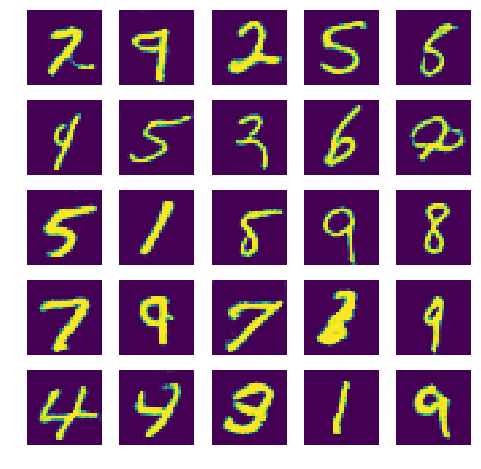

Generator(
  (layer1): Sequential(
    (0): Linear(in_features=100, out_features=25088, bias=True)
    (1): BatchNorm1d(25088, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), p

In [40]:
from IPython.display import clear_output
from tqdm import tqdm_notebook

discriminator.train()
generator.train()
for epoch in range(epochs):
    for j, (images, labels) in enumerate(tqdm_notebook(train_loader, total=len(train_loader))):
        optimizer_discriminator.zero_grad()
        loss = discriminator_loss(images.to("cuda"), sample_fake(batch_size)) + discriminator_penalty(images.to("cuda"))
        loss.backward()
        optimizer_discriminator.step()
        if j % discriminator_iterations_per_generator == 0:
            #discriminator.eval()
            #generator.train()
            optimizer_generator.zero_grad()
            loss = generator_loss(sample_fake(batch_size))
            loss.backward()
            optimizer_generator.step()
            #generator.eval()
            #discriminator.train()

    if epoch % validation_interval == 0:
        clear_output(wait=True)
        print("Epoch #" + str(epoch))
        generator.eval()
        imgs = sample_fake(25).cpu().detach().numpy()
        generator.train()
        #plot_images(imgs.clip(0, 1))
        plot_images(imgs)
        plt.show()

discriminator.eval()
generator.eval()

In [62]:
torch.save(generator, "generator.pt")
torch.save(discriminator, "discriminator.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


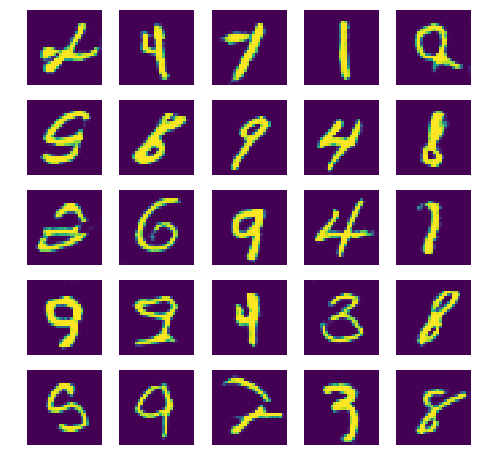

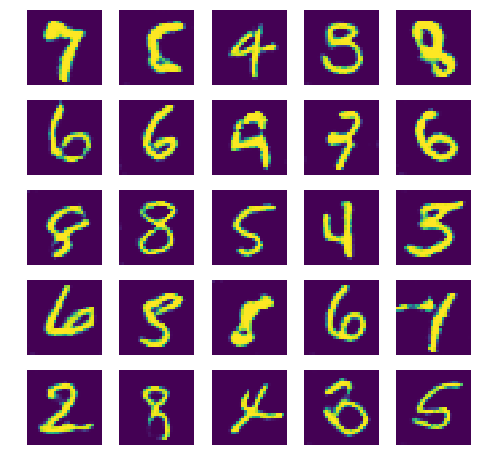

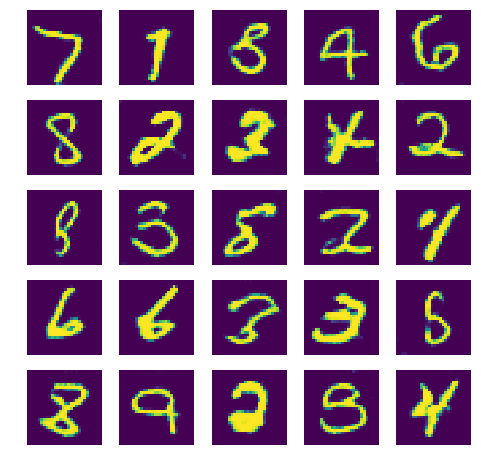

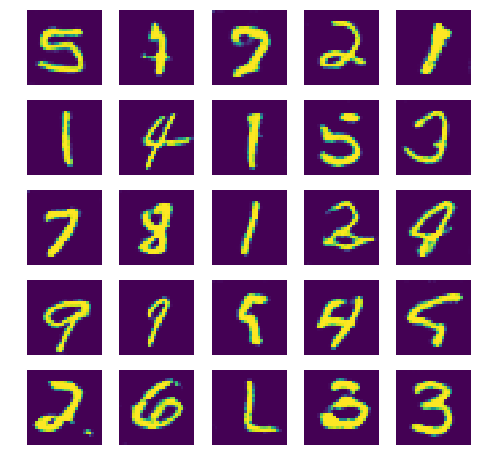

In [41]:
generator.eval()
plot_images(sample_fake(25).cpu().detach().numpy())
plt.show()
plot_images(sample_fake(25).cpu().detach().numpy())
plt.show()
plot_images(sample_fake(25).cpu().detach().numpy())
plt.show()
plot_images(sample_fake(25).cpu().detach().numpy())
plt.show()

## AnoGAN. Этап 2. Подсчёт расстояния до нормальных объектов и подбор 

## Задание 3
Реализуйте расстояние до аномалий согласно формуле, предложенной в [статье](https://arxiv.org/abs/1703.05921):
$$L(x,G_z)=(1-\lambda)|x-G_z| + \lambda|D(x)-D(G_z)|$$, где x - аномалия (или нормальный объект), $G_z=G(z)$ - объект, сгенерированный генератором $G$ из латентного представления $z\in Z$

In [59]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x,G_z,Lambda=0.1): # расстояние до аномалии x до G_z. На выходе должен возвращаться тензор (batch_size,)
    loss_residual = torch.abs(x - G_z).sum(dim=[1, 2, 3])
    loss_discrimination = torch.abs(discriminator(x)[0] - discriminator(G_z)[0]).sum(dim=1)
    return (1 - Lambda) * loss_residual + Lambda * loss_discrimination

In [114]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

start_idx = 64
train_size = 500


train_data_mnist = mnist_train.__dict__['data'][start_idx:start_idx+train_size]
train_label_mnist = mnist_train.__dict__['targets'][start_idx:start_idx+train_size] == anomaly_digit # 0 - нормальный объект, 1 - аномалия
train_data_mnist = train_data_mnist.view(train_size,1,28,28).type_as(torch.FloatTensor())
train_data_mnist.size()

torch.Size([500, 1, 28, 28])

## Задание 4
Теперь, имея расстояние между двумя объектами, найдите ближайших соседей в латентном пространстве $Z$ для каждого из объектов выборки train_data_mnist. Поиск ближайшего соседа для каждого из объектов производится путём градиентной минимизации расстояния по переменной $z$.

Имея теперь расстояние до ближайшего соседа для каждого объекта выборки train_data_mnist, можно интерпретировать это расстояние как скор модели - чем больше это расстояние, тем больше вероятность, что ваш объект - аномалия, и наоборот.

Посмотрите, как по мере обучения (по мере поиска ближайшего соседа) меняется это расстояние. Принимая это расстояние за скор модели, посмотрите, как по мере обучения меняется ROC AUC. Сравните результат с baseline. Стало ли лучше?

In [124]:
z = Variable(init.normal(torch.zeros(train_size,100),mean=0,std=0.1),requires_grad=True) # для каждого объекта берём случайный нормальный объект в латентном пространстве в качестве начального соседа
#z_optimizer = torch.optim.Adam([z],lr=1e-4) # задаём оптимизатор для поиска ближайшего z к нашим аномалиям
z_optimizer = torch.optim.Adam([z], lr=0.02) # задаём оптимизатор для поиска ближайшего z к нашим аномалиям

gen_fake = generator(z.cuda())
loss = Anomaly_score(Variable(train_data_mnist).cuda(),gen_fake) # расстояние до нормального соседа. Путём минимизации этого расстояния будем находить расстояние до ближайшего соседа
print(loss.shape)
print(loss.mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """Entry point for launching an IPython kernel.


torch.Size([500])
tensor(23439.6191, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
from sklearn.metrics import roc_auc_score
train_data_mnist_cuda = Variable(train_data_mnist).cuda()
train_label_source = mnist_train.__dict__['targets'][start_idx:start_idx+train_size]
losses = []
roc_auc = []
losses_ordinary_mean = []
losses_anomaly_mean = []

for i in tqdm_notebook(range(5000)):
    z_optimizer.zero_grad()
    loss_each = Anomaly_score(train_data_mnist_cuda, generator(z.cuda()))
    loss = loss_each.sum()
    loss_ordinary = loss_each[~train_label_mnist]
    loss_anomaly = loss_each[train_label_mnist]
    losses.append(loss.item())
    losses_ordinary_mean.append(loss_ordinary.mean().item())
    losses_anomaly_mean.append(loss_anomaly.mean().item())
    roc_auc.append(roc_auc_score(train_label_mnist, loss_each.cpu().detach().numpy()))
    loss.backward()
    z_optimizer.step()
    if (i+1) % 3 == 0:
        #clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.xlabel("Iteration")
        plt.ylabel("Mean loss")
        plt.plot(np.arange(i+1), losses_anomaly_mean, label="anomaly")
        plt.plot(np.arange(i+1), losses_ordinary_mean, label="ordinary")
        #for digit in range(10):
        #    plt.hist(loss_each[train_label_source == digit].cpu().detach().numpy(), bins=30, density=True, histtype="step", alpha=0.5, label=str(digit))
        plt.legend()
        plt.savefig("loss_mean.pdf")
        #plt.show()
        
        plt.figure(figsize=(10, 5))
        plt.xlabel("Iteration")
        plt.ylabel("ROC AUC")
        plt.plot(np.arange(i+1), roc_auc)
        plt.savefig("roc_auc.pdf")
        #plt.show()
        
        plt.figure(figsize=(10, 5))
        plt.title("Iteration #{:d}".format(i))
        plt.xlabel("Loss")
        plt.hist(loss_anomaly.cpu().detach().numpy(), bins=30, density=True, alpha=0.5, label="anomaly")
        plt.hist(loss_ordinary.cpu().detach().numpy(), bins=30, density=True, alpha=0.5, label="ordinary")
        plt.legend()
        plt.savefig("loss_dist.pdf")
        #plt.show()

## Задание 5
Посмотрим на ближайших соседей

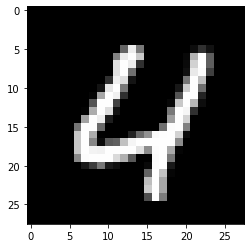

real data


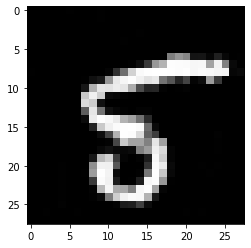

nearest neighbour

------------------------------------



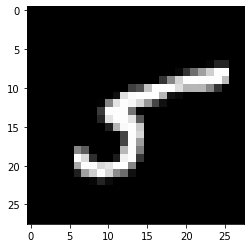

real data


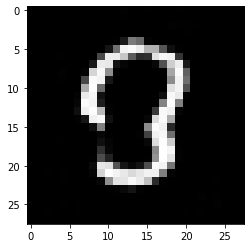

nearest neighbour

------------------------------------



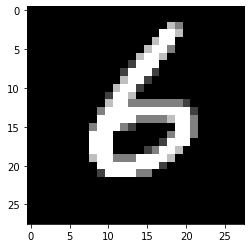

real data


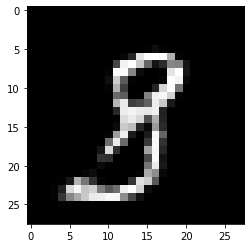

nearest neighbour

------------------------------------



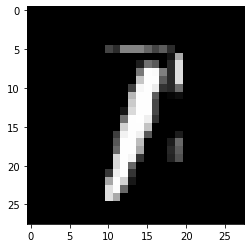

real data


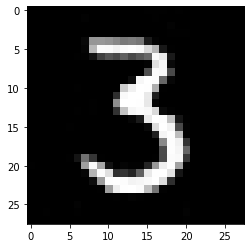

nearest neighbour

------------------------------------



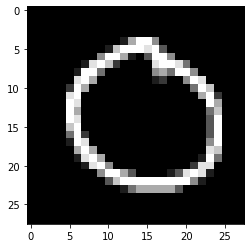

real data


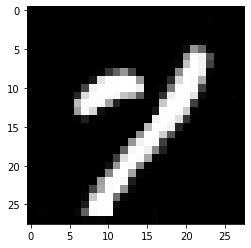

nearest neighbour

------------------------------------



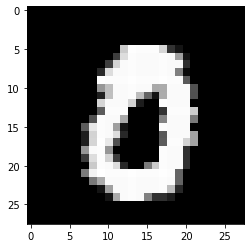

real data


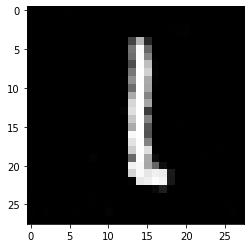

nearest neighbour

------------------------------------



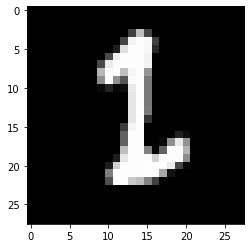

real data


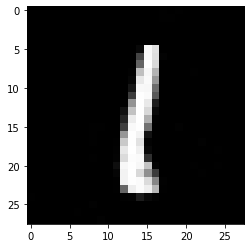

nearest neighbour

------------------------------------



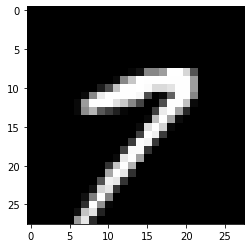

real data


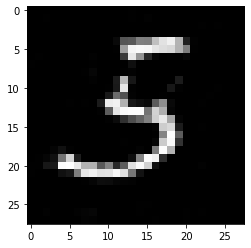

nearest neighbour

------------------------------------



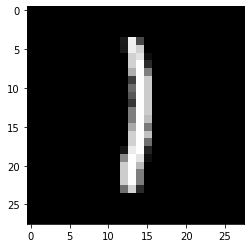

real data


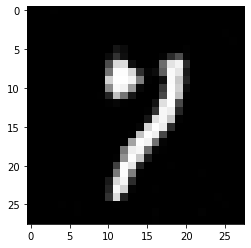

nearest neighbour

------------------------------------



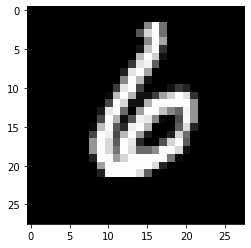

real data


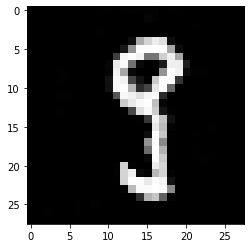

nearest neighbour

------------------------------------



In [0]:
??? # Write your code here

## Задание 6
Построим распределение расстояний для нормальных и аномальных объектов.
Что можно сказать, глядя на это распределение?

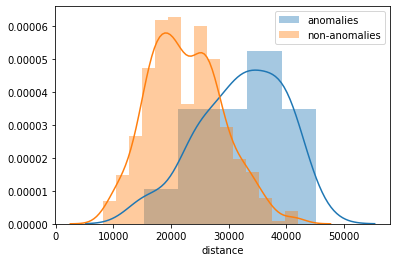

In [0]:
%matplotlib inline
import seaborn as sns
sns.distplot(loss[train_label_mnist].detach().cpu().numpy(), label='anomalies')
sns.distplot(loss[~train_label_mnist].detach().cpu().numpy(), label='non-anomalies')
plt.xlabel('distance')
plt.legend()

## Задание 7 (*)
Попробуйте обучить baseline (классификатор) на большем количестве аномалий. Стал ли классификатор работать лучше AnoGAN и, если да, с какого момента?